Diese Notebook erzeugt eine Visualisierung der Verteilung der F1 Scores mit einem kde plot und einem Histogramm.

In [1]:
import joblib
import numpy as np
from sklearn.metrics import f1_score
import yaml
import h5py

model_path = '../03 - Training/models/07-12-25 13-44-13.joblib'
importance_path = '../03 - Training/output/exp_03_12_feature_importance.joblib'

top_n_features = 25
feature_file = '../03 - Training/features/features.hdf5'
data_split_file = '../03 - Training/data_split.yaml'
split_val = 'val'
split_test = 'test'
label_str = 'labels_0.3_treshold'

importance = joblib.load(importance_path)
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:top_n_features]

clf = joblib.load(model_path)

macro_f1_scores = []
regular_f1_scores = []
inversed_f1_scores = []

with open(data_split_file) as f:
    data_split = yaml.safe_load(f)

relevant_patients = data_split[split_test]

with h5py.File(feature_file) as f:
    for session in f:
        feature_matrix_list = []
        label_vector_list = []
        if session.split('_')[0] not in relevant_patients:
            continue
        for channel in f[session]:
            label_vector_list.append(f[session][channel][label_str][:])
            feature_vector_list = []
            features = [feat for feat in f[session][channel].keys() if not feat.startswith('labels')]
            for feature in features:
                feature_vector_list.append(f[session][channel][feature][:])
            feature_matrix_list.append(np.column_stack(feature_vector_list))

        X_val, y_val = np.vstack(feature_matrix_list), np.concatenate(label_vector_list)
        X_val = X_val[:, top_n_features_idx]

        y_pred = clf.predict(X_val)
        macro_f1_scores.append(f1_score(y_val, y_pred, average='macro'))
        regular_f1_scores.append(f1_score(y_val, y_pred))
        inversed_f1_scores.append(f1_score(y_val, y_pred, pos_label=0))



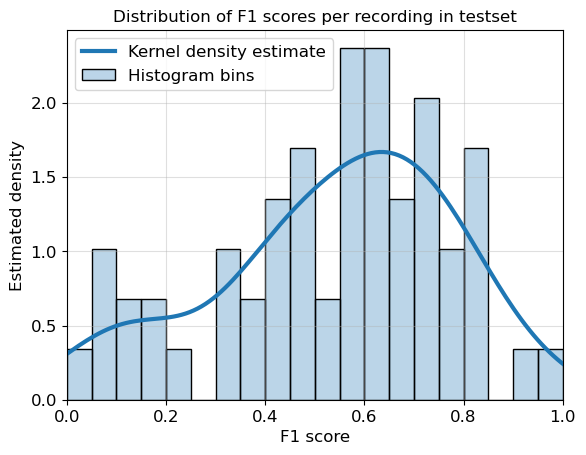

In [2]:
from matplotlib import pyplot as plt
from seaborn import kdeplot, histplot

kdeplot(regular_f1_scores, linewidth=3, label='Kernel density estimate')
histplot(regular_f1_scores, stat='density', alpha=0.3, label='Histogram bins', bins=20, binrange=(0, 1))
plt.xlim(0, 1)
plt.xlabel('F1 score', fontsize=12)
plt.ylabel('Estimated density', fontsize=12)
plt.title('Distribution of F1 scores per recording in testset', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.grid(True, alpha=0.4)
plt.savefig('output/exp_04_04_f1_per_recording_density.pdf', bbox_inches='tight')
plt.show()